# Analyzing SOFC data (part 6)

##6) Adding the temperature dimension
D\* and k\* are both thermally activated coefficients. Diffusion at low temperatures is much slower because atoms vibrate with lower amplitude and this makes it tougher for ions to pass through atomic gaps in the crystals. However, low temperatures are much more practical from an engineering standpoint.

In this notebook I will extend my model, currently only analyzed at 1000K, to lower temperatures and see how well it holds up.

In [11]:
from sofc_func import *
%matplotlib inline

In [23]:
# Import using pandas
df = pd.read_csv("data.csv")

# Clean out rows where there is no parent A or parent B

data = df[pd.notnull(df['A_par']) & pd.notnull(df['B_par']) & pd.notnull(df['d_star']) & pd.notnull(df['k_star']) 
             & pd.notnull(df['e affinity(B)']) & pd.notnull(df['d-electron count (B)'])]

pd.options.mode.chained_assignment = None

data = features(df)

temps = [400,500,600,700,800,900,1000]
for i in temps:
    data['dk_'+str(i)] = pd.Series(dk_star(data,i), index=df.index)

full_data = data[pd.notnull(data['EA_A']) & pd.notnull(data['EA_B']) & pd.notnull(data['r_A'])
        & pd.notnull(data['r_B']) & pd.notnull(data['d_count_B']) & pd.notnull(data['avg_EA_A'])
        & pd.notnull(data['avg_EA_B']) & pd.notnull(data['avg_r_A']) & pd.notnull(data['avg_r_B'])
        & pd.notnull(data['avg_d_count_B']) & pd.notnull(data['dk_'+str(temps[0])]) ]

In [13]:
def get_predictions(iterations, len_data, order, X, Y):
    predictions = []
    for cycle in range(iterations):
        cycle_predictions = []
        #lko = cross_validation.KFold(len_data, n_folds=k, shuffle=True)
        lko = cross_validation.LeavePOut(len_data, 1)
        for train_index, test_index in lko:
            x_train, x_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            model = make_pipeline(PolynomialFeatures(order), Ridge()).fit(x_train, y_train)
            cycle_predictions.append(model.predict(X))
        predictions.append(np.mean(np.array(cycle_predictions), axis=0))
    p = np.mean(np.array(predictions), axis=0)
    return p

###Model performance as a function of temperature:
I will run several model performance appraisals at temperatures 400-1000K and plot the results.

In [21]:
scores = []
stds = []

In [17]:
models = {}
d_star = {}
k_star = {}
X = full_data[['avg_EA_B']]
iterations = 4

start = time.clock()
for i in temps:
    y = full_data['dk_'+str(i)]
    o = optimize_order(iterations,len(y), 1, np.array(X), np.array(y), True)
    score, std = get_scores(iterations, 1, o, len(y), np.array(X), np.array(y), True)
    scores.append(score)
    stds.append(std)
    print 'Temperature: '+ str(i)+ ' Polynomial order: '+ str(o) + ' MSE: ' + str(score) + ' +/- ' + str(std)
    models[str(i)] = get_predictions(iterations, len(y), o, np.array(X), np.array(y))
print 'Executed in ' + str(time.clock()-start) + 's'

Temperature: 400 Polynomial order: 3 MSE: 311968.593111 +/- 0.0
Temperature: 500 Polynomial order: 5 MSE: 81988.8721668 +/- 0.0
Temperature: 600 Polynomial order: 5 MSE: 24185.9253807 +/- 0.0
Temperature: 700 Polynomial order: 5 MSE: 7678.37192149 +/- 0.0
Temperature: 800 Polynomial order: 5 MSE: 2608.79327223 +/- 0.0
Temperature: 900 Polynomial order: 5 MSE: 999.706934357 +/- 0.0
Temperature: 1000 Polynomial order: 5 MSE: 481.51720233 +/- 0.0
Executed in 13.702952s


Unlike the models in previous notebooks, these have a high polynomial order. 8th order polynomial functions are not physical, but remember that the regularization smooths these functions so they may resemble something meaningful. I am not sure why these are higher order, but let's plot them and take a look.

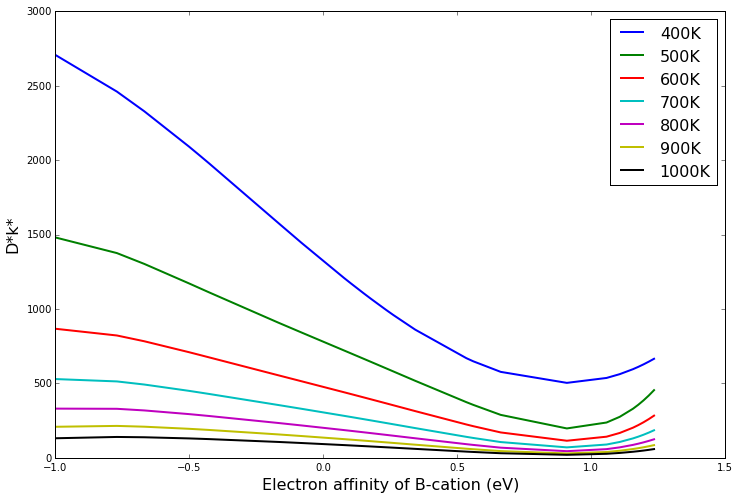

In [20]:
labels = []
plt.figure(figsize=(12,8))
for temp in temps:
    plt.plot(X, models[str(temp)], label=str(temp)+'K', linewidth=2)
    plt.ylabel('D*k*', fontsize=16)
    plt.xlabel('Electron affinity of B-cation (eV)', fontsize=16)
    #plt.title('ln(D*k*) as a function of temperature', fontsize=24)
    labels.append(str(temp)+'K')
plt.legend(labels, fontsize=16)
plt.show()

###Return of categorical variables.
I will add family and sample type dummy variables to the model with EN_B and numerically evaluate the performance of those models.

In [24]:
fam = pd.get_dummies(full_data['family'], prefix='family')
sam = pd.get_dummies(full_data['sample_type'], prefix='s')

full_data = full_data.drop('family', axis=1)
full_data = full_data.drop('sample_type', axis=1)

full_data = pd.concat([full_data, fam], axis=1)
full_data = pd.concat([full_data, sam], axis=1)


X = full_data[['avg_EA_B','avg_d_count_B', 'avg_EA_B', 's_Ceramic', 
          's_Single Crystal', 's_Thin Film','avg_d_count_B', 'avg_EA_B', 'family_Perovskite', 
          'family_Ruddlesden-Popper', 'family_Double Perovskite']]

#Sort by avg_EA_B
full_data = full_data.sort(['avg_EA_B'])

This is still consistent with what I saw earlier: at 800-1000K, the function looks like a 3rd order polynomial. At higher temperatures, it looks more quadratic, with a flatter tail at lower electron affinities.

* **At all temperatures, D\*k\* reaches a minimum at ~1 eV average electron affinity of the B-site cation.**
* At lower temperatures, the increase is steeper and the minimum is a higher value of D\*k\*. This is consistent for thermally activated behavior.
* D\*k\* increases more sharply going >1 eV than going lower 


###Plotting model scores:

In [26]:
X = full_data[['avg_EA_B', 
         's_Ceramic','s_Thin Film', 's_Single Crystal', 
         'family_Perovskite','family_Double Perovskite', 'family_Ruddlesden-Popper']]

In [27]:
models = {}
d_star = {}
k_star = {}

iterations = 5

start = time.clock()
for i in temps:
    y = full_data['dk_'+str(i)]
    o = optimize_order(iterations,len(y), 1, np.array(X), np.array(y), True)
    #score, std, r2, r2_std = get_scores(iterations, 1, o, len(y), np.array(X), np.array(y), True)
    models[str(i)] = get_predictions(iterations, len(y), o, np.array(X), np.array(y))
print 'Executed in ' + str(time.clock()-start) + 's'

Executed in 455.94143s


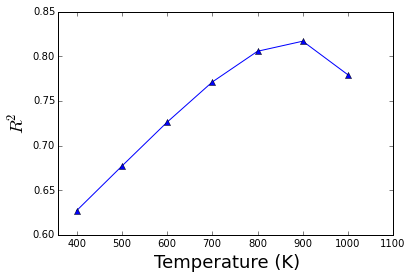

In [29]:
from sklearn.metrics import r2_score
r2s = []
for i in temps:
    r2s.append(r2_score(models[str(i)], full_data['dk_'+str(i)]))

plt.plot(temps, r2s, marker='^')
plt.xlim(0.9*np.min(temps), 1.1*np.max(temps) )
plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r"$R^2$", fontsize=18)
#plt.title('Model fit vs temperature')
plt.show()

From this we can see that the model's R^2 is generally proportional to temperature. The model doesn't do as well at lower temperatures and peaks at 900K, which is in the high temperature range.

#Conclusion:
Across all temperatures, average electron affinity of the B-site cation is the best indicator of diffusion. D\*k\* is best modeled with a 3rd order, regularized polynomial function of avg_EA_B. The model, however, performs best from 700-1000K and loses insight at temperatures below.

The loss in predictability may come from the fact that most of the measured values are extrapolated from measurements at higher temperatures. The Arrhenius behaviour should theoretically extend predictions to all temperatures, but phase changes, microstructures, and defects make this a bit unrealistic.

As for the peak performance of this model, roughly 20% of the variation is left unexplained and none of the other features in this analysis were able to shed significant, additional insight. This comes from the difficult nature of this problem. There are many, many environmental and material factors affecting each measurement that go beyond composition of the material itself, which is the only factor from which these features were derived.

#Added conclusion:
The data shouldn't be analyzed as a whole because perovskites and double perovskites diffuse by assisted vacancy migration, while Ruddlesden-Popper materials diffuse by interstitial migration. In notebook 8, I will separate the two subsets and run the same analysis performed here.